# Graph Classification

## Graph Classes

we use the following graph classes:
- Chemical Graphs (Molecules)
- Random
- Small World
- Scale Free

## Setup

We use pyg (pytorch-geometric) to generate the model to train.
The model is a GCN with 2 layers and 32 hidden units.

In [ ]:
import torch_geometric
import torch

print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.mps.is_available())
print(torch_geometric.__version__)

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx

# we need to read the dataset from the pickle file
import pickle

with open('dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

for key in dataset.keys():
    print(f"datasetkey: {key}, shape: {len(dataset[key])}")

# we need to convert the networkx graphs to pytorch geometric graphs

class_key = dict(zip(dataset.keys(), range(len(dataset.keys()))))
print(class_key)
pyg_dataset = []
for key in dataset.keys():
    for i in range(len(dataset[key])):
        graph = dataset[key][i]
        graph_tensor = from_networkx(graph, group_node_attrs=["label", "betweenness", "degree"])
        graph_tensor.y = torch.tensor([class_key[key]])
        pyg_dataset.append(graph_tensor)

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx
import pickle


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return ['data.pt']


    def process(self):
        # Read data into huge `Data` list.
        with open('dataset.pickle', 'rb') as f:
            dataset = pickle.load(f)

        class_key = dict(zip(dataset.keys(), range(len(dataset.keys()))))
        print(class_key)
        data_list = []
        for key in dataset.keys():
            for i in range(len(dataset[key])):
                graph = dataset[key][i]
                graph_tensor = from_networkx(graph, group_node_attrs=["label", "betweenness", "degree", "density"])
                graph_tensor.y = torch.tensor([class_key[key]])
                data_list.append(graph_tensor)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
import torch
from torch_geometric.datasets import TUDataset

pyg_dataset = MyOwnDataset(root='data/CustomData')

print()
print(f'Dataset: {pyg_dataset}:')
print('====================')
print(f'Number of graphs: {len(pyg_dataset)}')
print(f'Number of features: {pyg_dataset.num_features}')
print(f'Number of classes: {pyg_dataset.num_classes}')

data = pyg_dataset[0]  # Get the first graph object.

print()
print(data)
print(data.x)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
torch.manual_seed(12345)
pyg_dataset = pyg_dataset.shuffle()

train_dataset = pyg_dataset[:600]
test_dataset = pyg_dataset[600:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
from model.gcn import GCN

model = GCN(hidden_channels=64, num_classes=pyg_dataset.num_classes,
            num_node_features=pyg_dataset.num_node_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


confusion_matrix = torch.zeros(3, 3)
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [79]:
print(model)

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=8, bias=True)
)


In [ ]:
torch.save(model.state_dict(), 'gnn_model_weights.pth')
torch.save(model, 'gnn_model.pth')

In [ ]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer

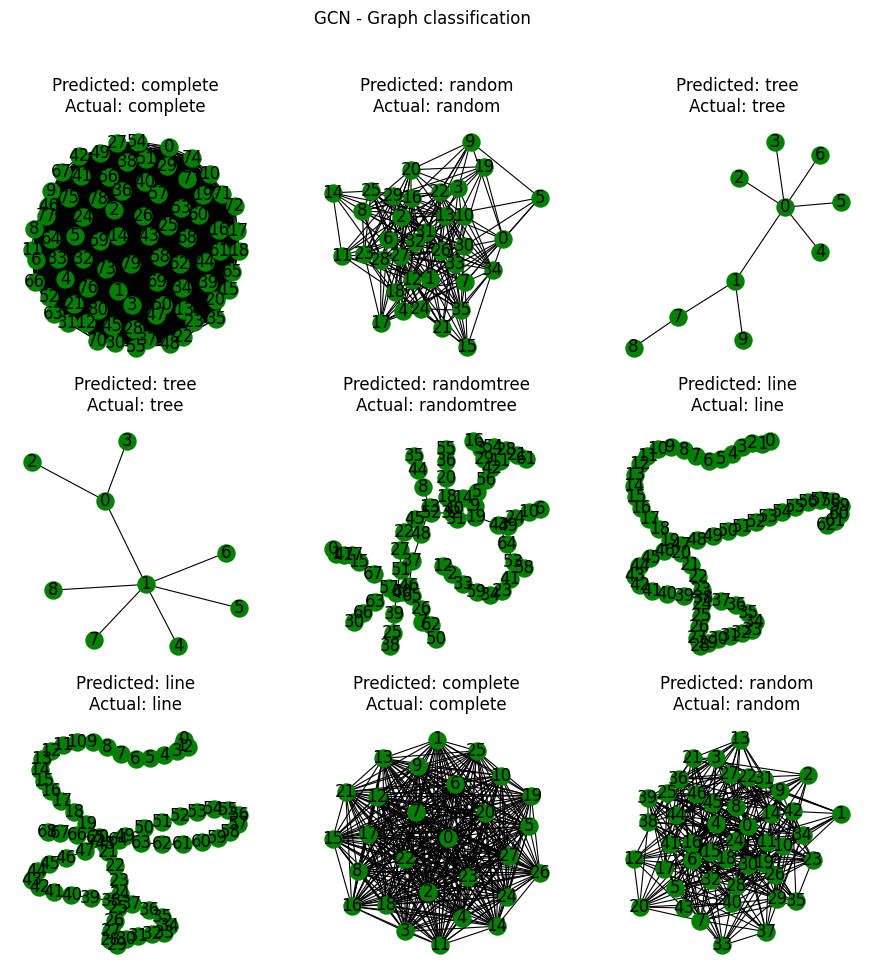

In [78]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from torch_geometric.utils import to_networkx
from model.gcn import GCN


class_key = dict(zip(dataset.keys(), range(len(dataset.keys()))))
class_key = {v: k for k, v in class_key.items()}

def index_to_class(index):
    return class_key[index]

fig, ax = plt.subplots(3, 3, figsize=(11, 11))
fig.suptitle('GCN - Graph classification')

shuffled_dataset = pyg_dataset.shuffle()

for i, data in enumerate(shuffled_dataset[:9]):
    # Calculate color (green if correct, red otherwise)
    out = model(data.x, data.edge_index, batch=data.batch)
    pred = out.argmax(dim=1)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    ax[ix].set_title('Predicted: ' + index_to_class(pred.item()) + '\nActual: ' + index_to_class(data.y.item()))
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=True,
                     node_size=150,
                     node_color=color,
                     width=0.8,
                     ax=ax[ix]
                     )


In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer


explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200)
)

# Generate explanation for the node at index `10`:
explanation = explainer(data.x, data.edge_index, index=10)
print(explanation.edge_mask)
print(explanation.node_mask)

explanation.visualize_feature_importance(top_k=10)

explanation.visualize_graph()